# TyBox experimental: incremental learning
A full description of the experiment is provided in the paper TyBox...

### prepare dependencies and data

In [1]:
pip install tybox-0.1.15-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./tybox-0.1.15-py3-none-any.whl


In [2]:
import TyBox

import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd
import math

!apt-get -qq install xxd

In [3]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
    train_examples = np.array(data['x_train'], dtype='float32')
    train_labels = data['y_train']
    test_examples = np.array(data['x_test'], dtype='float32')
    test_labels = data['y_test']

layer = tf.keras.layers.Normalization(axis=None)
layer.adapt(train_examples)
train_examples = np.array(layer(train_examples))
test_examples = np.array(layer(test_examples))

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
source_data_examples = []
source_data_labels = []
target_data_examples = []
target_data_labels = []
for i in range(len(train_examples)):
  if train_labels[i] % 2 == 0:
    source_data_examples.append(train_examples[i])
    source_data_labels.append(int(train_labels[i] / 2))
  else:
    target_data_examples.append(train_examples[i])
    target_data_labels.append(int((train_labels[i] - 1) / 2))
source_data_examples = np.array(source_data_examples)
source_data_labels = np.array(source_data_labels)
target_data_examples = np.array(target_data_examples)
target_data_labels = np.array(target_data_labels)

### create and train model, save a copy, create tybox models

In [5]:
filters = 8
model = keras.Sequential()
model.add(keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(filters, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(5, activation='softmax'))
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')
print(model.layers[4].output.shape)
model.fit(source_data_examples, source_data_labels, epochs=5)

(None, 200)
Epoch 1/5
922/922 [==============================] - 19s 20ms/step - loss: 0.2267 - accuracy: 0.9284
Epoch 2/5
922/922 [==============================] - 18s 20ms/step - loss: 0.0795 - accuracy: 0.9742
Epoch 3/5
922/922 [==============================] - 9s 10ms/step - loss: 0.0553 - accuracy: 0.9822
Epoch 4/5
922/922 [==============================] - 10s 10ms/step - loss: 0.0457 - accuracy: 0.9854
Epoch 5/5
922/922 [==============================] - 10s 11ms/step - loss: 0.0402 - accuracy: 0.9876


In [6]:
model.save('model')

In [ ]:
# this cell is to load a previously prepared model to save time
model = keras.models.load_model('model')

In [7]:
Mf_lite, Mc_manual_python, M_c, Mc_manual_header, Mf_header, Mf_cc = TyBox.util.create_on_device_learning_solution(model, None)
M_c.compile(loss='mean_squared_error', metrics='accuracy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.015))

1/1 [==============================] - 0s 71ms/step


debug [200, 5]


In [8]:
M_c.save_weights('mc_trained')

### extract features from data

In [9]:
with open("mf.tflite", "wb") as file:
  file.write(Mf_lite)
interpreter = tf.lite.Interpreter('/content/mf.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

extracted_features = []
for i in range(len(train_labels)):
  if i%20000 == 0:
    print(i)
  input_data = train_examples[i].astype('float32').reshape((1, 28, 28, 1))
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()
  out = interpreter.get_tensor(output_details[0]['index'])
  extracted_features.append(out)
extracted_features = np.array(extracted_features)[:,0,:]

extracted_source_data_examples = []
extracted_target_data_examples = []
for i in range(len(extracted_features)):
  if train_labels[i] % 2 == 0:
    extracted_source_data_examples.append(extracted_features[i])
  else:
    extracted_target_data_examples.append(extracted_features[i])

extracted_source_data_examples = np.array(extracted_source_data_examples)
extracted_target_data_examples = np.array(extracted_target_data_examples)

categorical_target_labels = np.zeros((13000, 5))
for i in range(13000):
  categorical_target_labels[i][target_data_labels[i]] = 1

categorical_source_labels = np.zeros((13000, 5))
for i in range(13000):
  categorical_source_labels[i][source_data_labels[i]] = 1

0
20000
40000


# Perform experiment with tensorflow model

In [10]:
buffer_tf = TyBox.Buffer(size_inputs=200, size_outputs=1, size_buffer=230)

repetitions = []
for repetition in range(5):
  res_x = []
  res_acc1 = []
  res_std = []

  M_c.load_weights('/content/mc_trained')
  M_c.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.025))

  for i in range(500):
    res_x.append(i)

    sample = np.random.randint(10000)
    sample_data = extracted_target_data_examples[sample]
    sample_label = target_data_labels[sample]
    buffer_tf.push(sample_data, sample_label)

    M_c.fit(buffer_tf.get_buffer_samples(), buffer_tf.get_buffer_labels(), epochs=1, verbose=0)
    accuracy = M_c.evaluate(extracted_target_data_examples[10000:10100], target_data_labels[10000:10100], verbose=0)[1]
    res_acc1.append(accuracy)
    print(i, accuracy)
  repetitions.append(res_acc1)

0 0.20999999344348907
1 0.20000000298023224
2 0.20000000298023224
3 0.20000000298023224
4 0.2800000011920929
5 0.33000001311302185
6 0.3499999940395355
7 0.30000001192092896
8 0.30000001192092896
9 0.3100000023841858
10 0.3100000023841858
11 0.33000001311302185
12 0.38999998569488525
13 0.3700000047683716
14 0.4099999964237213
15 0.4099999964237213
16 0.4300000071525574
17 0.41999998688697815
18 0.4300000071525574
19 0.3799999952316284
20 0.4699999988079071
21 0.49000000953674316
22 0.5199999809265137
23 0.5099999904632568
24 0.5400000214576721
25 0.550000011920929
26 0.550000011920929
27 0.550000011920929
28 0.5799999833106995
29 0.5899999737739563
30 0.6000000238418579
31 0.5899999737739563
32 0.5899999737739563
33 0.6499999761581421
34 0.6600000262260437
35 0.6600000262260437
36 0.6600000262260437
37 0.6700000166893005
38 0.6600000262260437
39 0.6600000262260437
40 0.6499999761581421
41 0.5699999928474426
42 0.6700000166893005
43 0.6600000262260437
44 0.6899999976158142
45 0.6700000

### visualize results

In [11]:
avg_repetitions = []
for i in range(len(repetitions[0])):
  avg = 0
  for ii in range(len(repetitions)):
    avg += repetitions[ii][i]
  avg = avg / len(repetitions)
  avg_repetitions.append(avg)

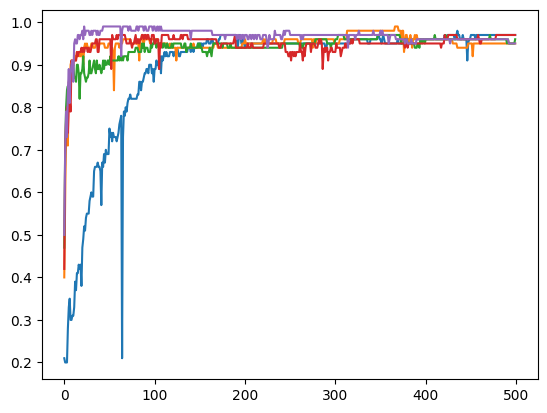

In [12]:
plt.figure()
plt.plot(repetitions[0])
plt.plot(repetitions[1])
plt.plot(repetitions[2])
plt.plot(repetitions[3])
plt.plot(repetitions[4])

<function matplotlib.pyplot.fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)>

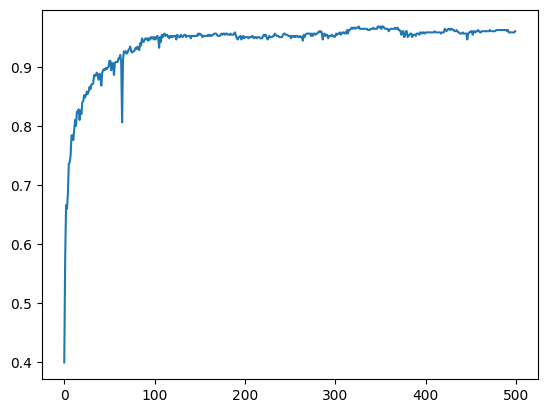

In [13]:
plt.plot(avg_repetitions)
plt.fill_between

In [14]:
std_dev_repetitions = []
for i in range(len(avg_repetitions)):
  std_dev = 0
  for ii in range(len(repetitions)):
    std_dev += (avg_repetitions[i] - repetitions[ii][i]) ** 2
  std_dev = math.sqrt(std_dev / len(repetitions))
  std_dev_repetitions.append(std_dev)

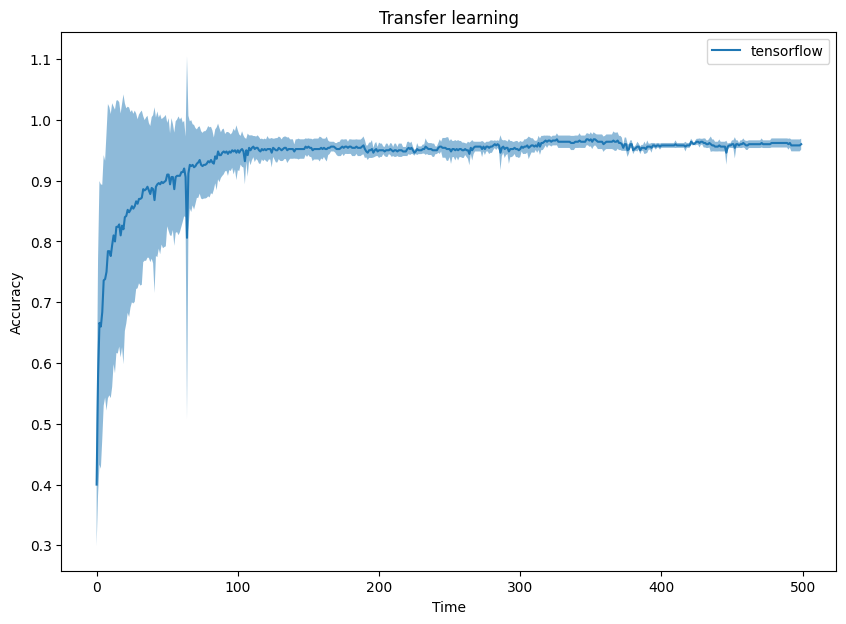

In [15]:
plt.figure(figsize=(10,7))


plt.plot(avg_repetitions, label="tensorflow")
std_low = [avg_repetitions[i] - std_dev_repetitions[i] for i in range(len(avg_repetitions))]
std_high = [avg_repetitions[i] + std_dev_repetitions[i] for i in range(len(avg_repetitions))]
plt.fill_between([i for i in range(500)], std_low, std_high, alpha=0.5)

plt.title("Transfer learning")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()

# Perform experiment with TyBox model

In [16]:
buffer_tb = TyBox.Buffer(size_inputs=200, size_outputs=5, size_buffer=230)

repetitions_tb = []
for repetition in range(5):
  res_x = []
  res_acc = []
  res_std = []

  M_c.load_weights('/content/mc_trained')
  M_c.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.025))

  python_model = TyBox.create_python_model(M_c)

  for i in range(500):
    res_x.append(i)

    sample = np.random.randint(10000)
    sample_data = extracted_target_data_examples[sample]
    sample_label = categorical_target_labels[sample]
    buffer_tb.push(sample_data, sample_label)

    python_model.train(buffer_tb.get_buffer_samples(), buffer_tb.get_buffer_labels(), 0.025)
    accuracy = python_model.evaluate(extracted_target_data_examples[10000:10100], categorical_target_labels[10000:10100])
    res_acc.append(accuracy)
    print(i, accuracy)
  repetitions_tb.append(res_acc)
  

debug [200, 5]
0 0.11
1 0.11
2 0.09
3 0.07
4 0.11
5 0.15
6 0.14
7 0.13
8 0.17
9 0.14
10 0.15
11 0.13
12 0.18
13 0.16
14 0.18
15 0.23
16 0.29
17 0.3
18 0.24
19 0.32
20 0.28
21 0.32
22 0.34
23 0.34
24 0.36
25 0.36
26 0.35
27 0.35
28 0.44
29 0.49
30 0.5
31 0.5
32 0.46
33 0.5
34 0.51
35 0.54
36 0.56
37 0.59
38 0.6
39 0.6
40 0.6
41 0.64
42 0.64
43 0.66
44 0.67
45 0.66
46 0.71
47 0.73
48 0.79
49 0.79
50 0.78
51 0.8
52 0.82
53 0.82
54 0.82
55 0.82
56 0.82
57 0.82
58 0.83
59 0.83
60 0.83
61 0.84
62 0.84
63 0.84
64 0.83
65 0.82
66 0.83
67 0.82
68 0.81
69 0.82
70 0.82
71 0.82
72 0.82
73 0.82
74 0.82
75 0.82
76 0.82
77 0.82
78 0.85
79 0.82
80 0.81
81 0.82
82 0.83
83 0.76
84 0.81
85 0.83
86 0.86
87 0.81
88 0.81
89 0.83
90 0.84
91 0.85
92 0.85
93 0.85
94 0.85
95 0.84
96 0.86
97 0.86
98 0.86
99 0.86
100 0.86
101 0.86
102 0.86
103 0.86
104 0.86
105 0.86
106 0.86
107 0.86
108 0.86
109 0.86
110 0.86
111 0.87
112 0.85
113 0.87
114 0.87
115 0.87
116 0.87
117 0.87
118 0.87
119 0.86
120 0.86
121 0.86
122 0

In [ ]:
repetitions_tb = [[],[],[],[],[]]
with open("transfer learn mnist tb", "r") as file:
  line = file.readline()
  i = 0
  while line != '':
    repetitions_tb[math.floor(i / 500)].append(float(line))
    line = file.readline()
    i += 1
repetitions = [[],[],[],[],[]]
with open("transfer learn mnist tf", "r") as file:
  line = file.readline()
  i = 0
  while line != '':
    repetitions[math.floor(i / 500)].append(float(line))
    line = file.readline()
    i += 1

FileNotFoundError: ignored

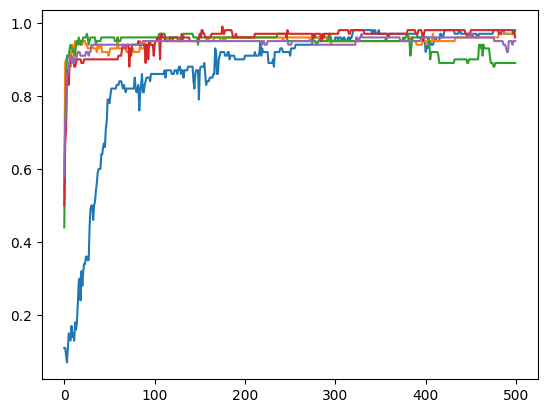

In [17]:
plt.figure()
for i in range(5):
  plt.plot(repetitions_tb[i])

In [18]:
avg_repetitions_tb = []
for i in range(len(repetitions_tb[0])):
  avg = 0
  for ii in range(len(repetitions_tb)):
    avg += repetitions_tb[ii][i]
  avg = avg / len(repetitions_tb)
  avg_repetitions_tb.append(avg)

In [19]:
std_dev_repetitions_tb = []
for i in range(len(avg_repetitions_tb)):
  std_dev = 0
  for ii in range(len(repetitions_tb)):
    std_dev += (avg_repetitions_tb[i] - repetitions_tb[ii][i]) ** 2
  std_dev = math.sqrt(std_dev / len(repetitions_tb))
  std_dev_repetitions_tb.append(std_dev)

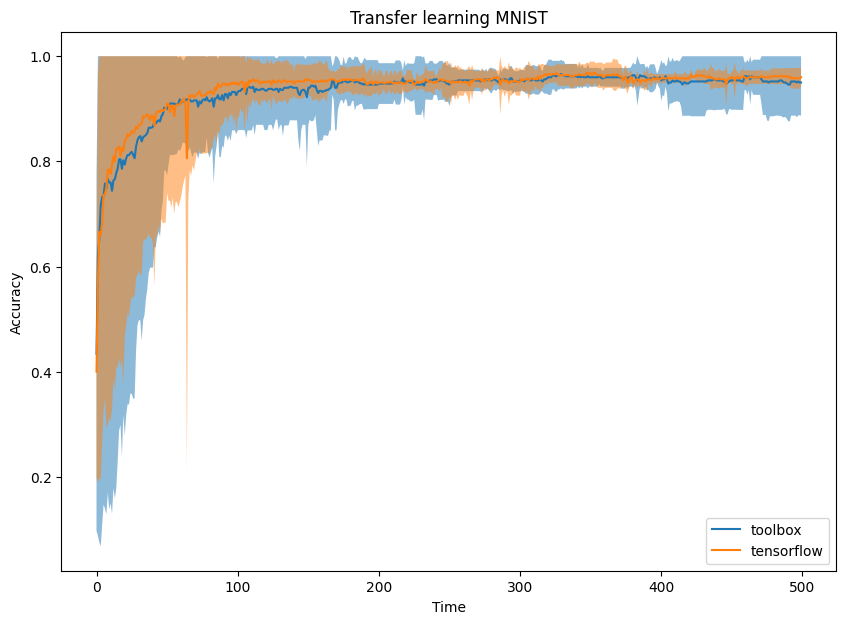

In [20]:
plt.figure(figsize=(10,7))

plt.plot(avg_repetitions_tb, label="toolbox")
std_low = [avg_repetitions_tb[i] - 2*std_dev_repetitions_tb[i] for i in range(len(avg_repetitions_tb))]
std_high = [min(avg_repetitions_tb[i] + 2*std_dev_repetitions_tb[i], 1) for i in range(len(avg_repetitions_tb))]
plt.fill_between([i for i in range(500)], std_low, std_high, alpha=0.5)

plt.plot(avg_repetitions, label="tensorflow")
std_low = [avg_repetitions[i] - 2*std_dev_repetitions[i] for i in range(len(avg_repetitions))]
std_high = [min(avg_repetitions[i] + 2*std_dev_repetitions[i], 1) for i in range(len(avg_repetitions))]
plt.fill_between([i for i in range(500)], std_low, std_high, alpha=0.5)

plt.title("Transfer learning MNIST")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend(loc=4)

In [21]:
with open("transfer learn mnist tf", "w") as file:
  for i in range(len(repetitions)):
    for ii in range(len(repetitions[i])):
      file.write(str(repetitions[i][ii]) + '\n')
with open("transfer learn mnist tb", "w") as file:
  for i in range(len(repetitions_tb)):
    for ii in range(len(repetitions_tb[i])):
      file.write(str(repetitions_tb[i][ii]) + '\n')
